### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2021 ###

### Final Course Project: Due 5/2/21, 11:59pm

# COVID Policy Optimization #

####  Jack Heidenreich (jheidenreic2@wisc.edu), James Ma (yma255@wisc.edu), Rebecca Mercer (rmercer2@wisc.edu)

*****

### Table of Contents

1. [Introduction](#introduction)
1. [Vaccine Distribution](#2.-Vaccine-Distribution)  
    a. [Mathematical Model](#2a)  
    b. [Preprocessing](#2b)  
    c. [Solution](#2c)  
    d. [Results/Discussion](#2d)  
1. [Lockdown Policy](#3.-Lockdown-Policy)  
    a. [Mathematical Model](#3a)  
    b. [Preprocessing](#3b)  
    c. [Solution](#3c)  
    d. [Results/Discussion](#3d) 
1. [Conclusion](#4.-Conclusion)
1. [Sources](#Sources)

# 1. Introduction <a name="introduction"></a>



For over a year now countries around the world have taken different approaches to combating the Covid-19 pandemic with mixed results. Millions of people have died from the coronavirus around the world and many of those deaths could’ve been prevented and can be prevented by taking appropriate measures. Leaders have struggled with implementing policies, like stay at home orders, to keep cases down while taking societal costs of lockdowns into consideration. In April 2020, unemployment rates in the United States rose to 14.8%, higher than recorded since 1948, as a result of the pandemic (https://fas.org/sgp/crs/misc/R46554.pdf). Lockdowns can be very successful at relieving overwhelmed hospitals, but the economic damage must be considered. As of May 1st 2021, the global case count sits at just above 151 million, 32 million of them in the United States. Fortunately, thanks to the hard work by researchers, scientists, and academics all over the world we now have vaccines, which may bring the pandemic closer to an end. With increasing vaccination numbers, daily deaths and new cases in the United States are declining. There are so many factors that go into mitigating the effects of the pandemic, but the two that we will be addressing are vaccine distribution and lockdowns. A speedy and equitable distribution of vaccines to individuals across the country and appropriate government-enforced lockdown will keep infection rates down in the United States.

It is important that people get vaccinated as quickly as possible. To make this happen health officials must decide where to send vaccines. They must be sent in appropriate quantities for the requirements and capacity of the areas receiving them. We are using vaccine allocation data from the CDC for the Pfizer, Moderna, and Janssen vaccinations in order to optimize vaccine distribution throughout the state of Wisconsin. Vaccine distribution must take into accounts the demographics of each county to ensure fairness to all residents as well as the capacity of vaccine administration. As vaccines increase lockdown policies can be lightened and as this happens we want to determine how long areas should lockdown for in order to help overwhelmed hospitals and rising infection rates. Data for this comes from Public Health Madison & Dane County website, the Wisconsin Department of Health and Services, and COVID-Act Now, a COVID risk tracking project.

In this project we propose optimal vaccine allocation focusing on equity and speed as well as optimal lockdown policies based on the trade off between rising infection rates/hospital occupancies and number of days in lockdown. We focus on the state of Wisconsin and these factors that are important on our road to recovery.

# 2. Vaccine Distribution #
This is the first of two models that contribute to developing optimal Covid policy. This model is meant to be dynamic, with the user updating the data and parameters as conditions change. We have data from the CDC about Wisconsin's vaccination efforts thus far. Based on the amount of each type of vaccine allocated to the state, and information about each county (demographics, essential workers, population density), we created a model that optimizes the distribution of vaccines to each county. There are some tradeoffs in our model that we had to balance to ensure fairness and efficiency. For example, we would not want to overload counties with too many vaccines in a week, as they likely wouldn't have the capacity to distribute them, wasting vaccines that could be used elsewhere. We also wanted there to be consistency week to week in how many vaccines are distributed to a county. Wild fluctuations in supply could cause confusion within the county and hurt vaccination efforts. Taking these considerations, and others, into account, we developed what we believe is an optimal plan for vaccine distribution in Wisconsin. In the following sections, we will detail some more of our methodology and reasoning behind decisions we made.

## 2a. Mathematical Model <a name="2a"></a>

#### Objective:
- Minimizing number of unused final doses (2nd of Pfizer/Moderna and any Janssen)
    - Squared difference between number in stock at beginning of week and how many people receive them
- Smoothing L1 Regularization term (Lasso Regression)
    - Minimize difference between number of doses given of each vaccine, between weeks
    - Prevent wild fluctuations in supply
- Sparsity Regularization term
    - Penalize counties that use many different types of vaccines

#### Variables:  
- Vaccines: Number of each type of vaccine allocated to each county, weekly (in units of vials)
- Stock: Amount of each type of vaccine at the beginning of each week (in units of doses)
- Penalty: Smoothing penalty (Absolute value of difference between vaccines given week to week)
- First/Final doses (Keep track of total first and final doses given in each week)
- Type: Binary variable to keep track if a vaccine is given in each county

#### Constraints:
- Sum of vaccines across a county in a given week cannot exceed its weekly capacity
- Stock of vaccine is zero until it can be distributed
- Weekly doses cant exceed weekly allotment plus the amount left over from previous week
- Second doses of Moderna/Pfizer cannot be administered until after 3/4 weeks the first shot
- Constrain first/final doses to be updated with appropriate values each week
- Constrain binary variables to determine whether a vaccine type is used in each county

#### Parameters
- County_capcity: Weekly vaccination capacity for each county
- $\lambda_1,\lambda_2$: regularization terms
- Week$_{V,W}$: Amount of each vaccine allocated to the state of Wisconsin, by week and vaccine type
- Start_week$_v$: The week that Vaccine type v begins to be distributed

$V = \{P_1, P_2, M_1, M_2, J\}$   

 
$$
\begin{aligned}
\underset{v,C,W \in \mathbb{R^n}}{\text{minimize}}\qquad& \sum_{v \in V}\sum_{c=1}^{72}\sum_{w=1}^{20}(Stock_{P2} + Stock_{M2}  + Stock_{J} - Total)^2 + \sum_{c=1}^{72}\sum_{w=1}^{20}\sum_{v \in V} Penalty_{v,C,W} + \lambda_2 \sum_{c=1}^{72}\sum_{w=1}^{20}\sum_{v \in V}Type_{v,C,W}    \\
\text{subject to:}\qquad& \sum_{w=1}^{20} \sum_{v\in V} Vaccines_{V,C,W} <= County\_Capacity_C && C=1,\dots,72   \\
& \sum_{c=1}^{72} Vaccines_{V,C,W} <= Week_{V,W-1} + Stock_{V,W-1} && W=1,\dots,20, v \in V\\ 
& Stock_{v,W-1} + Week_{v,W-1} - \sum_{C=1}^{72} Vaccines_{v,C,W-1}  == Stock_{v,W} && W=1,\dots,20, v \in V\\  
& Stock_{v,W} == 0 && W=1,\dots,Start\_week_v, v \in V \\  
& Vaccines_{V,C,W} \ge 0 && W=1,\dots,20, C=1,\dots,72, v \in V\\
& Stock_{V,W} \ge 0 && W=1,\dots,20, v \in V \\
& Penalty_{V,C,W} \ge 0 && W=1,\dots,20, C=1,\dots,72, v \in V\\
& Total \ge 0 \\
& Type_{V,C,W}, Binary && W=1,\dots,20, C=1,\dots,72, v \in V\\
\end{aligned}
$$

#### Model Type 
The above formulation is an outline of our final model, as we added some specific constraints that were difficult to reflect in the language above. Overall, we have a quadratic program (QP). We have continuous variables, boolean variables, and a convex objective function that we are minimizing. In practice, it would make sense to have all of our variables be discrete as you cannot give someone a fraction of a dose. However, this would complicate our model and increase our runtime even more, so we relaxed those constraints and made them continuous. The only integer variable we used is a binary variable to determine which types of vaccines are used where. Even though this relaxed model will give slightly different results, rounding down to the nearest integer will give a solution similar to the unconstrained optimal solution.



## 2b. Preprocessing <a name="2b"></a>
Our vaccine distribution model relied on a lot of data from various sources. In order to get it in a useable format, we had to do some web-scraping and preprocessing. The following sections detail some of the work we did to get the data we needed.

### Wisconsin vaccine allocation ###
The following chunks of code read in data from csv files given by various sources. Data about the Pfizer, Moderna, and Janssen vaccines are given. For Moderna and Pfizer, data was given for doses one and two. We assume that these are kept separate, as the second doses are saved to ensure someone that got a first dose is guaranteed the second. Note that the Janssen vaccine allocation was paused due to health concerns, so that allocation cuts off abruptly

In [63]:
using CSV, DataFrames
## Pfizer Wisconsin allocation Data
P_Week = zeros((20,3))
pfizer_weekly = CSV.read(joinpath(@__DIR__, "Pfizer.csv"), DataFrame)
pfizer_weekly = filter(row -> !(row.Jurisdiction != "Wisconsin"), pfizer_weekly)
pfizer_weekly = select!(pfizer_weekly, Not(:Jurisdiction))
(m,n) = size(pfizer_weekly)
# Find the week the vaccines start to be distributed
p_start_week = 1
count = p_start_week - 1
for current in eachrow(pfizer_weekly)
    index = 20 - count
    count += 1
    P_Week[index,1] = index
    P_Week[index,2] = current.DoseOne
    P_Week[index,3] = current.DoseTwo
end

In [64]:
## Moderna wisconsin allocation Data
M_Week = zeros((20,3))
moderna_weekly = CSV.read(joinpath(@__DIR__, "Moderna.csv"), DataFrame)
moderna_weekly = filter(row -> !(row.Jurisdiction != "Wisconsin"), moderna_weekly)
moderna_weekly = select!(moderna_weekly, Not(:Jurisdiction))
(m,n) = size(moderna_weekly)
# Find the week the vaccines start to be distributed
m_start_week = 2
count = m_start_week
M_Week[1,1] = 1
# Get number distributed for each week
for current in eachrow(moderna_weekly)
    index = 20 - count + 2
    count += 1
    M_Week[index,1] = index
    M_Week[index,2] = current.DoseOne
    M_Week[index,3] = current.DoseTwo
end

In [65]:
## J&J wisconsin allocation Data
J_Week = zeros((20,3))
janssen_weekly = CSV.read(joinpath(@__DIR__, "Janssen.csv"), DataFrame)
janssen_weekly = filter(row -> !(row.Jurisdiction != "Wisconsin"), janssen_weekly)
janssen_weekly = select!(janssen_weekly, Not(:Jurisdiction))
(m,n) = size(janssen_weekly)
for i in 1:20
    J_Week[i,1] = i
end
# Find the week the vaccines start to be distributed
j_start_week = 13
count = 0
# Get number distributed for each week
for current in eachrow(janssen_weekly)
    index = 18 - count
    count += 1
    J_Week[index,2] = current.DoseOne
end

### Wisconsin Vaccine Distribution Capacity ###

One major concern of ours was determining capacity for each state to distribute vaccines. We based it off of limited data we had from the State of Wisconsin on their efforts thus far. Since the data is combined into Wisconsin as a whole, we estimated county capacity proportional to its population. Although there are some county-level factors that would change individual capacities, such as Dane County having higher capacity due to the prevalent healthcare industry, we believe our estimates will still be adequate. To account for some counties needing higher priority, we increased the capacity of counties with a greater amount of essential workers, or minority populations, and decreased capacity for more rural communities (low population density). We also assumed that 85% of the population of a county is uner 16, and therefore ineligible for a vaccine.

In [66]:
## Avg daily throughput for whole state
dailyAdministered = CSV.read(joinpath(@__DIR__, "DailyAdministered.csv"), DataFrame)
weekly_vaccines = zeros((20,))
avg_daily_vaccines = 0
week = 1
cnt = 1
for curr in eachrow(dailyAdministered)
    value = replace(curr[2], ","=>"")
    avg_daily_vaccines += parse(Int64, value)
    weekly_vaccines[week] += floor(parse(Int64, value)/2)
    if ((cnt % 14) == 0)
        week += 1
    end
    cnt += 1
end
avg_daily_vaccines = floor(avg_daily_vaccines/m)
weekly_vaccines[19] = weekly_vaccines[18]
weekly_vaccines[20] = weekly_vaccines[18]
print()

In [67]:
# Get relevant demographic data
using Statistics
demographics = CSV.read(joinpath(@__DIR__, "counties_demographic.csv"), DataFrame)
ess_workers_mean = mean(demographics[:,"%ess_workers"])
white_mean = mean(demographics[:,"%white"])
print()

In [68]:
# Get county proportions based on population and different demographics (essential workers and minority populations)
county_pop = CSV.read(joinpath(@__DIR__, "wisc_county_populations.csv"), DataFrame)
total_pop = 0
eligible_pop = []
county_list = []
for current in eachrow(county_pop)
    total_pop += current[3]
end
fraction_pop = zeros((72,2))
i = 1
for current in eachrow(county_pop)
    fraction_pop[i,1] = current[1]
    fraction_pop[i,2] = (current[3]*.85)/total_pop
    if demographics[i,"%ess_workers"] > ess_workers_mean
        fraction_pop[i,2]*=1.2
    end
    if demographics[i,"%white"] < white_mean
        fraction_pop[i,2]*=1.1
    end
    if current[5] < mean(county_pop[:,"Density"])
        fraction_pop[i,2]*=.95
    end
    append!(eligible_pop, current[3]*.85)
    append!(county_list, [current[2]])
    i += 1
end

In [69]:
## Define county capacity as % of population * avg daily vaccines for whole state
county_capacity = zeros((72,20))
i = 1
for current in eachrow(fraction_pop)
    for j in 1:20
        county_capacity[i,j] = floor(current[2]*weekly_vaccines[j])
    end
    i += 1
end

## 2c. Solution <a name="2c"></a>

### Assumptions ###

In the formulation of our model we made some important assumptions that may affect how one interprets the results:
- We assumed that only 85% of any given county is eligible for the vaccine, due to estimates from our sources for age demographics in Wisconsin. Along with this, we are assuming that all of the 85% plans to get vaccinated. There are a lot of people against getting the Covid vaccine, which could limit vaccination rates.
- We assumed the number of vaccines given to be continuous, altough in practice it must be a discrete integer value. Because of the large number of vaccines given, we relaxed this constraint to help with runtime cost. The optimal integer solution will still be very similar to our continuous solution, and we recommend rounding down.
- As the Janssen vaccine data shows, there may be unexpected events that could affect distribution. For example, the Janssen vaccine was abruptly halted for multiple weeks while investigations were being done into side effects. Although we now know this occurred, we could not build this into our model, or else it would account for this upcoming event before anyone knew it was going to occur. Even though the Janssen vaccine was halted in week 18, we still continue to distribute the vaccines, as it could get re-authorized any day
- Although this model predicts 20 weeks in advance, we recommend to use this model dynamically, and re-run with different parameters as conditions change
- We assume that first and second doses of Moderna and Pfizer are kept separate. Although they could theoretically use vaccines designated as a second dose as a first dose, we assume they save the second doses to guarantee they do not run out when someone somes back for their second dose. In addition, we assume they come back exactly on schedule with when they should (3 or 4 weeks depending on type)
- Assume county has ability to meet capacity, if capacity not met, we assume those doses will be reallocated to counties that can handle it

### Vaccination Distribution Model ###


In [70]:
using Suppressor
using Gurobi, JuMP

# Parameters that can be changed as circumstances change
num_weeks = 20
num_counties = 72
num_days = 7
num_types = 5

# Number of vaccine doses available in each vial
P_vial = 6
M_vial = 11
J_vial = 5

m = Model(Gurobi.Optimizer)

# Number of each type of vaccine vials sent to each county, in each week
@variable(m, 0 <= P1[1:num_counties,1:num_weeks]) 
@variable(m, 0 <= M1[1:num_counties,1:num_weeks])
@variable(m, 0 <= P2[1:num_counties,1:num_weeks])
@variable(m, 0 <= M2[1:num_counties,1:num_weeks])
@variable(m, 0 <= J[1:num_counties,1:num_weeks])

# Stock from end of previous week, in doses
@variable(m, 0 <= P1_stock[1:num_weeks])
@variable(m, 0 <= M1_stock[1:num_weeks])
@variable(m, 0 <= P2_stock[1:num_weeks])
@variable(m, 0 <= M2_stock[1:num_weeks])
@variable(m, 0 <= J_stock[1:num_weeks])

# Number of full series of shots given each week
@variable(m, 0 <= final_doses[1:num_weeks])
@variable(m, 0 <= first_doses[1:num_weeks])

# Binary variable representing if a vaccine type is used in a county
@variable(m, P_used[1:num_counties], Bin)
@variable(m, M_used[1:num_counties], Bin)
@variable(m, J_used[1:num_counties], Bin)

# Upper limit on vaccines used
# If the number of vaccines of a given type in a county is >1, the binary variable associated with it must be 1
M_upper = 1e7
@constraint(m, vac_type_P[j in 1:num_counties], sum(P1[j,i] for i in 1:num_weeks) <= M_upper*P_used[j])
@constraint(m, vac_type_M[j in 1:num_counties], sum(M1[j,i] for i in 1:num_weeks) <= M_upper*M_used[j])
@constraint(m, vac_type_J[j in 1:num_counties], sum(J[j,i] for i in 1:num_weeks) <= M_upper*J_used[j])

# Weekly differences in number of vaccines administered is penalized
# Need these constraints to reflect absolute value
@variable(m, 0 <= penalty[1:num_counties,1:num_weeks-1,1:num_types])
for i in 1:19
    i2 = i + 1
    for j in 1:num_counties
        @constraint(m, (P1[j,i2] - P1[j,i]) <= penalty[j,i,1])
        @constraint(m, (P1[j,i2] - P1[j,i]) >= -penalty[j,i,1])
        @constraint(m, (P2[j,i2] - P2[j,i]) <= penalty[j,i,2])
        @constraint(m, (P2[j,i2] - P2[j,i]) >= -penalty[j,i,2])
        @constraint(m, (M1[j,i2] - M1[j,i]) <= penalty[j,i,3])
        @constraint(m, (M1[j,i2] - M1[j,i]) >= -penalty[j,i,3])
        @constraint(m, (M2[j,i2] - M2[j,i]) <= penalty[j,i,4])
        @constraint(m, (M2[j,i2] - M2[j,i]) >= -penalty[j,i,4])
        @constraint(m, (J[j,i2] - J[j,i]) <= penalty[j,i,5])
        @constraint(m, (J[j,i2] - J[j,i]) >= -penalty[j,i,5])
    end  
end

# Vaccines administered per day cant exceed county capacity
for i in 1:num_counties
    for j in 1:num_weeks
        @constraint(m, (P1[i,j]*P_vial + M1[i,j]*M_vial + P2[i,j]*P_vial + M2[i,j]*M_vial + J[i,j]*J_vial) <= county_capacity[i,j])
    end
end

# The stock of vaccines is zero until the type of vaccine starts to be allocated by the government
@constraint(m, P1_stock[1] == 0)
@constraint(m, M1_stock[1:m_start_week] .== 0)
@constraint(m, P2_stock[1] == 0)
@constraint(m, M2_stock[1:m_start_week] .== 0)
@constraint(m, J_stock[1:j_start_week] .== 0)

# Weekly doses cant exceed weekly allotment + left over from previous week
for i in 2:21
    if (i==21)
        @constraint(m, 0 <= P1_stock[i-1] + P_Week[i-1,2] - sum(P1[k,i-1]*P_vial for k in 1:num_counties))
        @constraint(m, 0 <= P2_stock[i-1] + P_Week[i-1,3] - sum(P2[k,i-1]*P_vial for k in 1:num_counties))
        @constraint(m, 0 <= M1_stock[i-1] + M_Week[i-1,2] - sum(M1[k,i-1]*M_vial for k in 1:num_counties)) 
        @constraint(m, 0 <= M2_stock[i-1] + M_Week[i-1,3] - sum(M2[k,i-1]*M_vial for k in 1:num_counties)) 
        @constraint(m, 0 <= J_stock[i-1] + J_Week[i-1,2] - sum(J[k,i-1]*J_vial for k in 1:num_counties)) 
    else
        @constraint(m, P1_stock[i] == P1_stock[i-1] + P_Week[i-1,2] - sum(P1[k,i-1]*P_vial for k in 1:num_counties)) 
        @constraint(m, P2_stock[i] == P2_stock[i-1] + P_Week[i-1,3] - sum(P2[k,i-1]*P_vial for k in 1:num_counties)) 
        @constraint(m, M1_stock[i] == M1_stock[i-1] + M_Week[i-1,2] - sum(M1[k,i-1]*M_vial for k in 1:num_counties)) 
        @constraint(m, M2_stock[i] == M2_stock[i-1] + M_Week[i-1,3] - sum(M2[k,i-1]*M_vial for k in 1:num_counties)) 
        @constraint(m, J_stock[i] == J_stock[i-1] + J_Week[i-1,2] - sum(J[k,i-1]*J_vial for k in 1:num_counties)) 
    end
end

# Ensure the number of days between first and second doses is accurate
# No Moderna second dose until day 28
for k in 1:num_counties
    for i in 1:num_weeks
        if (i <= 4)
            @constraint(m, M2[k,i] == 0)
        else
            @constraint(m, M2[k,i] == M1[k,(i-4)])
        end
    end
end
# No Pfizer second dose until day 21
for k in 1:num_counties
    for i in 1:num_weeks
        if (i <= 3)
            @constraint(m, P2[k,i] == 0)
        else
            @constraint(m, P2[k,i] == P1[k,(i-3)])
        end
    end
end

# Compute total first and second doses in each week
for i in 1:num_weeks
    @constraint(m, final_doses[i] == sum(P2[k,i]*P_vial + M2[k,i]*M_vial + J[k,i]*J_vial for k in 1:num_counties)) 
    @constraint(m, first_doses[i] == sum(P1[k,i]*P_vial + M1[k,i]*M_vial for k in 1:num_counties))
    
end

# Regularization parameters that affect smoothing between weeks and sparsity

lambda1 = 5e7
lamdba2 = 1e8

# Objective function
# Minimizes the difference between second doses available and the amount given in each week
# Regularization terms for smoothing between weeks, and sparsity of vaccine types
@objective(m, Min, sum(((P2_stock .+ M2_stock .+ J_stock) .- final_doses).^2) + lambda1 * sum(penalty) + lamdba2*(sum(P_used+M_used+J_used)))

@suppress begin
    optimize!(m)
end

## 2d. Results/Discussion <a name="2d"></a>
Using the solution of our model, we created some different visualizations to show the important features of our results. Our results are given the specific parameters and tradeoffs we decided upon when formulating this model. In practice, the user of this model can adjust anything necessary to meet their needs. For example, one could input future vaccine allocation estimates to figure out vaccine distribution past week 20

### Total Doses in Wisconsin Given by Week ###

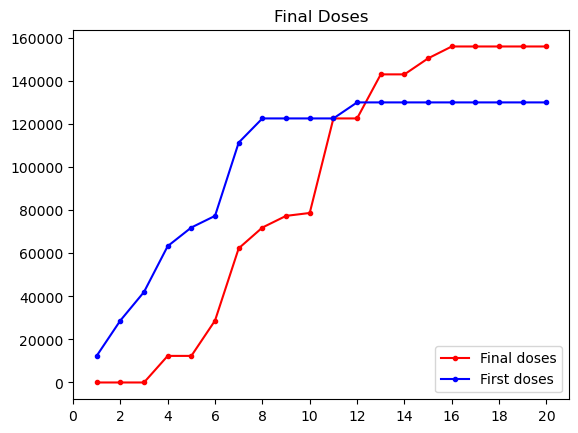

In [71]:
using PyPlot
x=1:20
plot(x,value.(final_doses),"r.-",x,value.(first_doses),"b.-")
legend(["Final doses","First doses"], loc="lower right");
title("Final Doses");
xticks(0:2:20)
print()

The plot shows the amount of first and final doses given per week in Wisconsin, aggregated across all counties. There is a consistent upward trend for the first 8 weeks of first doses, and then flattens out. This is reflects the allocation given to Wisconsin. The final doses trend is mirroring that of first doses, lagging 3 weeks behind. As the Janssen vaccines are introduced in the later weeks, though, their trends diverge.

### Total Pfizer Doses Given by Week ###

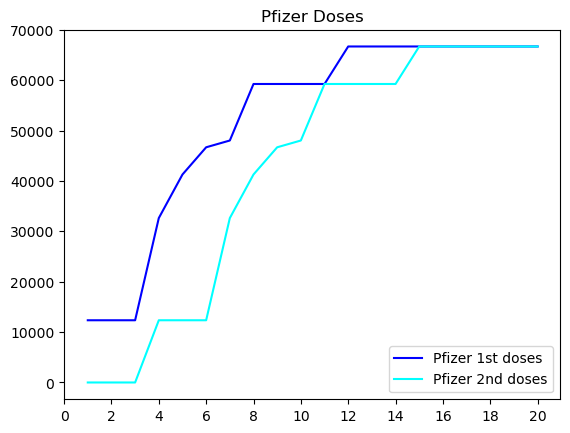

In [72]:
pfizer_1 = zeros((20,))
pfizer_2 = zeros((20,))
for i in 1:num_counties
    for j in 1:num_weeks
        pfizer_1[j] += value(P1[i,j])*P_vial
        pfizer_2[j] += value(P2[i,j])*P_vial
    end
end
plot(x,pfizer_1,:blue,x,pfizer_2,:cyan)
legend(["Pfizer 1st doses", "Pfizer 2nd doses"], loc="lower right");
title("Pfizer Doses")
xticks(0:2:20)
print()

This plot shows the amount of 1st and 2nd doses of Pfizer given in each week, aggregated across all counties. As it should, the 2nd dose trend is almost exactly the same as the 1st, but lagging 3 weeks behind, due to the wait time between doses. In practice, some people may miss their second dose or get it slightly off schedule, but the doses still need to be distributed there on time, so we assume it happens exactly on schedule.

### Total Moderna Doses Given by Week ###

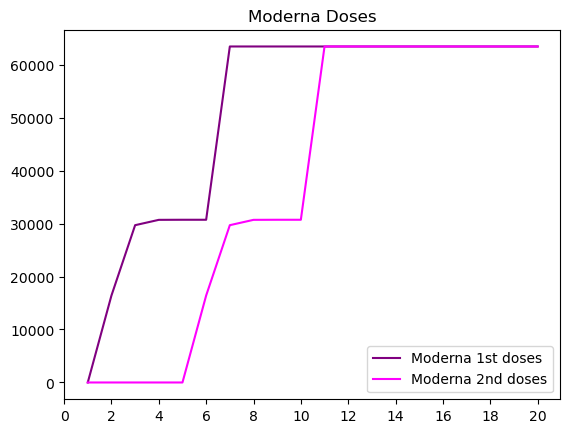

In [73]:
m_1 = zeros((20,))
m_2 = zeros((20,))
for i in 1:num_counties
    for j in 1:num_weeks
        m_1[j] += value(M1[i,j])*M_vial
        m_2[j] += value(M2[i,j])*M_vial
    end
end
plot(x,m_1,:purple,x,m_2,:magenta)
legend(["Moderna 1st doses", "Moderna 2nd doses"], loc="lower right");
xticks(0:2:20)
title("Moderna Doses")
print()

This plot shows the amount of 1st and 2nd doses of Moderna given in each week, aggregated across all counties. As it should, the 2nd dose trend is almost exactly the same as the 1st, but lagging 4 weeks behind, due to the wait time between doses.

### Janssen Doses Given by Week ###

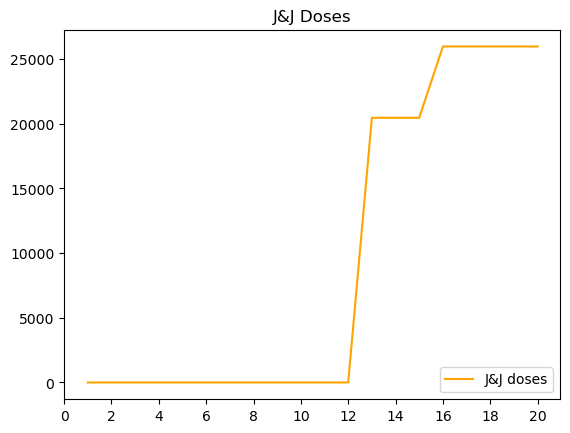

In [74]:
jj = zeros((20,))
for i in 1:num_counties
    for j in 1:num_weeks
        jj[j] += value(J[i,j])*J_vial
    end
end
plot(x,jj,:orange)
legend(["J&J doses"], loc="lower right");
title("J&J Doses")
xticks(0:2:20)
print()

This plot shows the distribution of Janssen doses across Wisconsin, aggregated by county. Distribution of these doses does not begin until week 13, and is paused week 18. Even though the administration of these vaccines gets paused, we still distribute them because if they get re-authorized they can be administered immediately.

### Example County Allocation of Vaccines by week ###

  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [91a5bcdd] + Plots v0.29.9
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


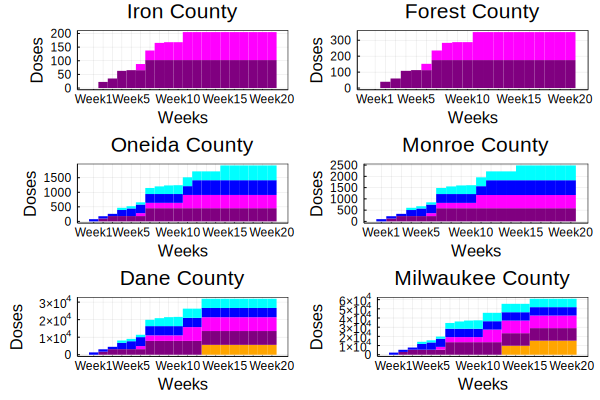

In [76]:
import Pkg; Pkg.add("Plots")
using StatPlots
function get_plots(c_list)
    plot_list = []
    for c in c_list
        plot_data = zeros((100,))
        for i in 1:20
            plot_data[i] += value(P1[c,i])*P_vial
            plot_data[i + 20] += value(P2[c,i])*P_vial
            plot_data[i + 40] += value(M1[c,i])*M_vial
            plot_data[i + 60] += value(M2[c,i])*M_vial
            plot_data[i + 80] += value(J[c,i])*J_vial
        end
        sx = repeat(["Pfizer Dose 1", "Pfizer Dose 2", "Moderna 1", "Moderna 2", "J&J"], inner = 20)
        nam = repeat(1:20, outer=5)
        plot1 = groupedbar(nam, bar_position = :stack, plot_data, group = sx, xlabel = "Weeks", ylabel = "Doses",
                title = string(county_list[c], " County"), bar_width = 1,
                lw = 0, framestyle = :box, color = [:orange :purple :magenta :blue :cyan],
                legend=:none, xticks = ([1:20;],["Week1", "", "", "", "Week5", "", "", "", "", "Week10","", "", "", "", "Week15", "", "", "", "", "Week20"]))
        push!(plot_list, plot1)
    end
    return plot_list
end
p1 = get_plots([3,5,33,43,71,72])
using Plots
Plots.plot(p1[1],p1[2],p1[3],p1[4],p1[5],p1[6], layout = (3,2))

We created stacked barplots to visualize the weekly allocation each county receives. Due to the sparsity regularization term we set, counties with smaller capcities receive a lesser variety of doses, and the counties with large capacities receive all types of vaccines. We wanted to give people in all counties a variety of options when getting a vaccine, but smaller counties may have trouble handling all of the different types. It would be much more efficient to train medical staff on one vaccine, rather than 3, especially if they aren't giving a large amount of them out.

### Tableau Visualization ###

In [77]:
part_vac = []
state = []
for j in 1:num_counties
    append!(part_vac, (sum(value.(P1[j,i]) for i in 1:num_weeks)*P_vial+sum(value.(M1[j,i]) for i in 1:num_weeks)*M_vial+sum(value.(J[j,i]) for i in 1:num_weeks)*J_vial  ))
    append!(state, ["Wisconsin"])
end
part_vac_percent = part_vac./eligible_pop
print()
using DataFrames
part_vac_df = DataFrame(County = county_list, 
               Part_Vac = part_vac,
               Eligible_Pop = eligible_pop,
               Part_Vac_Percent = part_vac_percent,
               State = state)
CSV.write("part_vac.csv",part_vac_df)
print()

![Wisconsin vaccination map](Wisc_vac_map.png)

Because Tableau is great for geogphraic visualizations of data, we exported our vaccination results to create a heat map of the different counties vaccinations rates. The one below shows the percentage of eligible population that will be at least partially vaccinated by the end of week 20. Because of some of the conditions we enacted upon county capacity, certain counties with have vaccination rates out of proportion with their population. For example, Dane and Milwaukee County have very high vaccination rates, due to their higher than average proportion of essential workers and minorities. Many rural communities, on the other hand have less than average vaccination rates, due to the condition put on more rural counties (low population density).

Our optimization model should be helpful in increasing the efficiency of vaccine distribution in Wisconsin. There are many complex relationships and constraints at play, and it can be difficult to do it fairly and successfully, while being able to quickly adapt to changing conditions. One event, such as the Janssen vaccines being halted, could have a significant impact if not reacted to quickly. Our model will be able to handle these unexpected events and recommend a solution immediately. By using predictions for future allocation amounts and the needs of Wisconsin, this model can be used to effectively distribute vaccines until the pandemic is over.

In the formulation of our model, we did make certain assumptions that could affect the performance of our model. When determining how many vaccines are sent to different counties, we also assumed they would all be used properly. However, as we are seeing as the vaccine was being released, there is a portion of the population against receiving the vaccine. If this trend continues, and events like severe side effects also keep occurring, the vaccinations being distributed could go to waste. There needs to be a close eye kept on the actual percentage of these distributed vaccines that are applied, and adjust the distribution accordingly.
****
However effective our vaccine distribution is, the reality of the situation is that many people will still contract the virus and become ill in the meantime. Even with our model, after 20 weeks the county with the highest vaccination rates is only less than 60%. Until we can reach an effective herd immunity level, restrictions will have to be put in place to limit the spread and effect of the virus. In our next model, we will provide suggestions for balancing the tradeoff between length of a lockdown and the effect it has on infection rates.

# 3. Lockdown Policy #
In this section, we will explore how to choose a lockdown policy that minimizes the number of new cases while ensuring that the number of days in lockdown does not surpass a socially acceptable threshold. A long lockdown can be tremendously damaging for the local economy, as businesses are required to shut down and employers are required to lay off workers. It has also shown to have mental health consequences (during lockdowns calls to suicide prevention and domestic abuse hotlines have skyrocketed). On the other hand, the absence of a lockdown may lead to unacceptable number of cases that could possibly overwhelm the hospital capacity of a certain region. Here we will present a generalized model that explores the tradeoff between lockdown duration and number of infections. 


## 3a. Mathematical Model <a name="3a"></a>

Our general quadratically constrained quadratic model is as follows. We will minimize some function $F_1(x)$, which represents the infection rate given $x$ number of days in lockdown while also minimizing $x$. We will add a penalty term $\lambda$ to represent the emphasis to be placed on minimizing lockdown days relative to minimizing infection rates. We recognize that situations can change and different states may have different circumstances, which is why we chose to kept our model flexible.

Our constraints include that 1. infection rate function $F_1(x)$ must be positive, and 2. less than or equal to a maximum infection rate threshold $maxInfectionRate$ that would overwhelm hospital capacity. Furthermore, as a long lockdown is infeasible due to its potential social cost and the possibility of declined adherence, lockdown variable $x$ must also sit below some threshold $maxLockdownDays$.


$$
\begin{aligned}
\underset{x \in \mathbb{R^n}}{\text{minimize}}\qquad& F_1(x) + \lambda x \\
\text{subject to:}\qquad& F_1(x) \ge 0\\
& F_1(x) \le maxInfectionRate \\
& x \le maxLockdownDays
\end{aligned}
$$

Below are two alternative mixed integer programs, each either minimizing just lockdown days or just infection rates. These are the two extreme cases, in which we only focus on one objective, and will allow us to see the effects of not taking the other into account. Here $lockdown_i$ is a binary variable representing whether day $i$ is in lockdown, $infectionRate_i$ representing the infection rate on day $i$, which is defined as the total positive case count on that day divided by the total positive case count on the previous day. The integer constraints help us model the relationship between whether a day is under lockdown and the infection rate. Namely, if $lockdown_i = 1$, then $infectionRate_i \le 0.5$, where 0.5 is an arbitrary value we set to represent a low infection rate due to a lockdown. Furthermore, if $lockdown_i = 0$, then $infectionRate_i \ge 1$, where 1 represents the relatively high infection rate caused by not locking down. Lastly, we have upper and lower bounds of 1.5 and 0.3 representing the maximum and minimum infection rates, allowing us to determine $upper_m$ and $lower_m$ to use for our integer constraints. Once again, these constants are arbitrary and only serve as placeholders, and may be determined through scientific research.

We will then minimize the total number of lockdown days. Given our data on cases in Wisconsin and model for how COVID spreads, we can then determine the total case count and lockdown days in each of these scenarios.


$$
\begin{aligned}
{\text{minimize}}\qquad& \sum_{i=1}^{400}lockdown_i \\
\text{subject to:}\qquad& infectionRate_i - 0.5 \le 1 * (1 + lockdown_i) \text{ for i = 1,2, ..., 400}\\
\qquad& infectionRate_i - 1 \ge -0.7 * lockdown_i \text{ for i = 1,2, ..., 400}\\
\qquad& lockdown_i, Binary \text{ for i = 1, 2, ..., 400}\\
\end{aligned}
$$


$$
\begin{aligned}
{\text{minimize}}\qquad& \sum_{i=1}^{400}infectionRate_i \\
\text{subject to:}\qquad& infectionRate_i - 0.5 \le 1 * (1 + lockdown_i) \text{ for i = 1,2, ..., 400}\\
\qquad& infectionRate_i - 1 \ge -0.7 * lockdown_i \text{ for i = 1,2, ..., 400}\\
\qquad& lockdown_i, Binary \text{ for i = 1, 2, ..., 400}\\
\end{aligned}
$$

## 3b. Data <a name="3b"></a>

In order to determine the mathematical relationship between lockdowns and infection rate, we will generate some synthetic data using Wisconsin's officially reported data. A shelter-in-place order was issued by Wisconsin governor Tony Evers on March 25, 2020 and lasted until April 24, 2020. 

In [78]:
# import cases dataframe
# contains daily case numbers from 3/15/2020 to 4/18/2021
cases = CSV.read(joinpath(@__DIR__, "COVID-19_Historical_Data_by_State.csv"), DataFrame)
(m,n) = size(cases)
sort!(cases, [:DATE])
cases = cases[:,[4,5,6,7]]
# placeholder for infection rate
inf_rate = DataFrame(INF_RATE = [0.0 for i in 1:400])
cases = hcat(cases, inf_rate)
# fill in data for infection rates
# infection rate on day i = total positive on day i / total positive on day i-1
for i in 2:400
    cases[i,5] = cases[i,2] / cases[i-1,2]
end
cases_before_order = cases[2:10,:] # select rows before stay at home order issued 3/25
print()

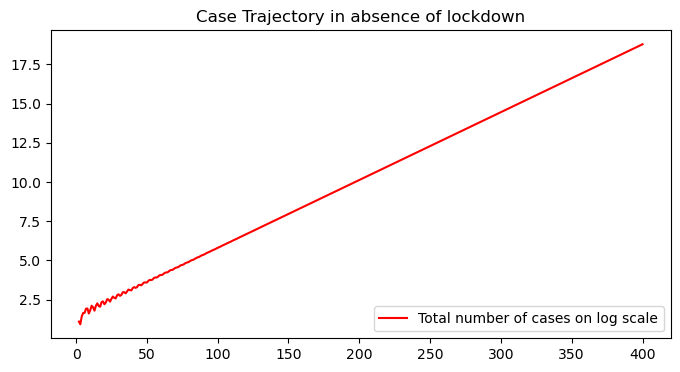

In [79]:
# use autoregressive model to model COVID numbers before 3/25 lockdown
l = 3
len = size(cases_before_order)[1]
new_cases = cases_before_order[1:len,3]
ar = zeros(len, l)
for i in 1:l
    ar[i+1:end,i] = new_cases[1:end-i]
end
wopt = ar\new_cases
yest = ar*wopt
# plot number of cases if no lockdown had been implemented on 3/25
# use data from 3/15 to 3/25 to predict trajectory of new cases
# use log scale

len2 = size(cases)[1]
for i in 10:len2
    prev = [yest[i-j] for j in 1:l]
    append!(yest, sum(wopt[j]*prev[j] for j in 1:l))
end
x = [i for i in 1:len2]
figure(figsize=(8,4))
plot(x, log10.(yest), "r-")
legend(["Total number of cases on log scale"], loc="lower right");
title("Case Trajectory in absence of lockdown")
print()

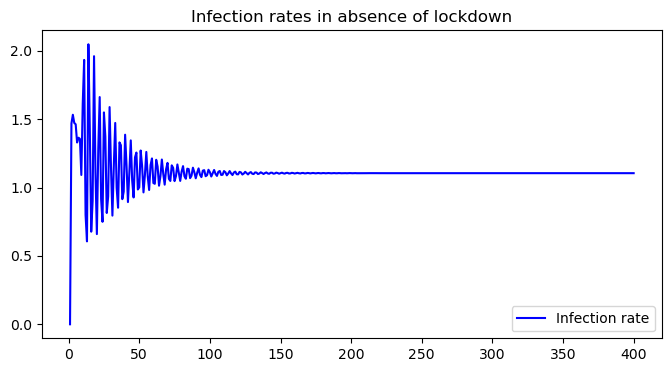

In [80]:
# infection rates from 3/15 to 4/24 in absence of lockdown
inf_rate = [cases[i,5] for i in 1:9]
for i in (10:400)
    append!(inf_rate, yest[i]/yest[i-1])
end
#inf_rate
x = [i for i in 1:len2]
figure(figsize=(8,4))
plot(x, inf_rate, "b-")
legend(["Infection rate"], loc="lower right");
title("Infection rates in absence of lockdown")
print()

Next we will attempt to model how the lockdown order affected the infection rate. To do so we fit a least squares model using k = 3. The results show a steady decline in infection rates, represented by the cubic polynomial fit 

$y = -1.149318192452676e-5x^3 + 0.0009495581490617729x^2 -0.025484187953690982x + 1.264122560375558$

where $y$ is the infection rate and $x$ is the number of days in lockdown.

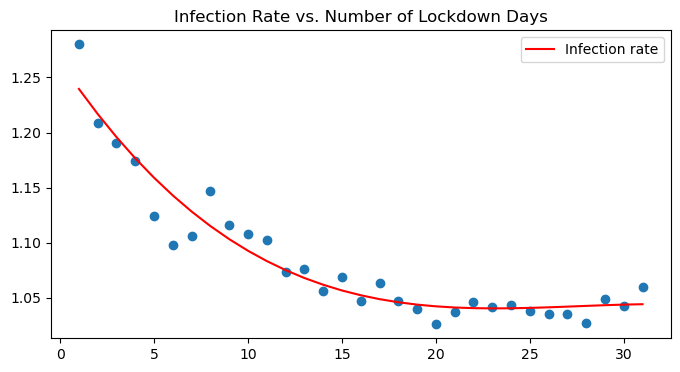

Optimal parameters: [-1.149318192452676e-5, 0.0009495581490617729, -0.025484187953690982, 1.264122560375558]


In [81]:
# plot of infection rates during lockdown order between 3/25 to 4/24
cases_during_orders = cases[11:41, :] # subset of cases dataframe from 3/25 to 4/24
x = [i for i in 1:31]
inf_rate = []
for i in 1:31
    append!(inf_rate, cases_during_orders[i,5])
end
    
figure(figsize=(8,4))

# fit least squares model for infection rate given number of lockdown days
k = 3
n = length(x)
A = zeros(n,k+1)
for i in 1:n
    for j in 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end
using JuMP, Gurobi
m = Model(Gurobi.Optimizer)

@variable(m, u[1:k+1])
@objective(m, Min, sum((inf_rate-A*u).^2))
optimize!(m)
uopt = value.(u)
yvals = value.(A*u)
println("Optimal parameters: ",uopt)
PyPlot.scatter(x, inf_rate)
plot(x, yvals, "r-")
title("Infection Rate vs. Number of Lockdown Days")
legend(["Infection rate"], loc="upper right")
print()

In [82]:
# hospital constraints for Wisconsin
dane_pos = 43973
dane_hosp = 1399
hosp_rate = dane_hosp/dane_pos
percent_beds_covid = 123/1615
wi_staffed_beds = 11053
println("Dane county has a total of ", dane_pos, " cases and ", dane_hosp, 
    " ever hospitalized, giving it a hospitalization rate of ", hosp_rate*100, "%.")
println("Wisconsin has a total of ", wi_staffed_beds, " staffed beds, ", percent_beds_covid*wi_staffed_beds, 
    " can be used for COVID-related hospitalizations.")
staffed_beds_for_covid = percent_beds_covid*wi_staffed_beds
print()

Dane county has a total of 43973 cases and 1399 ever hospitalized, giving it a hospitalization rate of 3.1814977372478563%.
Wisconsin has a total of 11053 staffed beds, 841.8074303405573 can be used for COVID-related hospitalizations.


## 3c. Solution <a name="3c"></a>

First we will look at two extreme cases, the first being only focusing on minimizing lockdown days, and the second minimizing only infection rates. We will use our collected data for Wisconsin cases up to day 22, which is when number of new cases surpasses 300, as a trigger for a lockdown.


In [83]:
# Model 1: minimize lockdown days
# lockdown[i] = 1 if lockdown during that day, else 0

# use known data (new cases and infection rate) for i = 1 to i = 22 
# trigger for lockdown: when daily new cases >= 300, i = 22 is first day this occurs

m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "OutputFlag", 0)

set_optimizer_attribute(m, "NonConvex", 2)
@variable(m, lockdown[1:400], Bin) # whether a certain day is in lockdown
@variable(m, new_cases[1:400]) # total number of new cases
@variable(m, infection_rate[1:400]) 

# first 22 days with new cases below 300 
for i in 1:22
    @constraint(m, new_cases[i] == no_order[i, 2])
    @constraint(m, infection_rate[i] == no_order[i,3])
end

# new cases on day i = new cases on day i-1 * infection rate on day i-1
for i in 23:400
    @constraint(m, new_cases[i] == new_cases[i-1]*(infection_rate[i-1]))
end

# # infection rate either 0.3 or 1 based on lockdown or not
# # lockdown[i] = 1 -> infection_rate[i] <= 0.5
# # infection_rate[i] - 0.5 <= M(1-lockdown[i]) where M = 1
# # max infection rate = 1.5
upper_m = 1
for i in 23:400
    @constraint(m, infection_rate[i] - 0.5 <= upper_m * (1 + lockdown[i]))
end

# # lockdown[i] = 0 -> infection_rate[i] >= 1
# # infection_rate[i] - 1 >= m * lockdown[i] where m = -0.7
# # min infection rate = 0.3
lower_m = -0.7
for i in 23:400
    @constraint(m, infection_rate[i] - 1 >= lower_m * lockdown[i])
end

@objective(m, Min, sum(lockdown[i] for i in 1:400))

optimize!(m)
println("total days in lockdown: ", sum(value.(lockdown)))
println("average infection rate: ", sum(value.(infection_rate))/400)
println("total new cases from day 23 to day 400: ", sum(value.(new_cases)[i] for i in 23:400))

total days in lockdown: 0.0
average infection rate: 1.0156574731748973
total new cases from day 23 to day 400: 210834.04964656808


In [84]:
# Model 2: minimize new cases
# lockdown[i] = 1 if lockdown during that day, else 0

# use known data (new cases and infection rate) for i = 1 to i = 22 
# trigger for lockdown: when daily new cases >= 300, i = 22 is first day this occurs

m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "OutputFlag", 0)

set_optimizer_attribute(m, "NonConvex", 2)
@variable(m, lockdown[1:400], Bin) # whether a certain day is in lockdown
@variable(m, new_cases[1:400]) # total number of new cases
@variable(m, infection_rate[1:400]) # infection rate of either 1 (no lockdown) or 0.3 (lockdown)

# first 22 days with new cases below 300 
for i in 1:22
    @constraint(m, new_cases[i] == no_order[i, 2])
    @constraint(m, infection_rate[i] == no_order[i,3])
end

# new cases on day i = new cases on day i-1 * infection rate on day i-1
for i in 23:400
    @constraint(m, new_cases[i] == new_cases[i-1]*(infection_rate[i-1]))
end

# # infection rate either 0.3 or 1 based on lockdown or not
# # lockdown[i] = 1 -> infection_rate[i] <= 0.5
# # infection_rate[i] - 0.5 <= M(1-lockdown[i]) where M = 1
# # max infection rate = 1.5
upper_m = 1
for i in 23:400
    @constraint(m, infection_rate[i] - 0.5 <= upper_m * (1 + lockdown[i]))
end

# # lockdown[i] = 0 -> infection_rate[i] >= 1
# # infection_rate[i] - 1 >= m * lockdown[i] where m = -0.7
# # min infection rate = 0.3
lower_m = -0.7
for i in 23:400
    @constraint(m, infection_rate[i] - 1 >= lower_m * lockdown[i])
end

@objective(m, Min, sum(infection_rate[i] for i in 1:400))
optimize!(m)
println("total days in lockdown: ", sum(value.(lockdown)))
println("average infection rate: ", sum(value.(infection_rate))/400)
println("total new cases from day 23 to day 400: ", sum(value.(new_cases)[i] for i in 23:400))

total days in lockdown: 378.0
average infection rate: 0.3529074731748975
total new cases from day 23 to day 400: 796.8029087172139



The results for model 1 are that we will spend 0 days in lockdown, achieving an average infection rate of 1.02 with 210,834 number of total new cases. This will surpass Wisconsin's hospital bed capacity of 11,053, which would be quite unacceptable.

The results for model 2 are that we will spend 378 days in lockdown, achieving an average infection rate of 0.35 with 797 number of total new cases. Though we will have a trivial number of new cases and a very small infection rate, spending 378 days in lockdown would be quite infeasible.

Our main model below minimizes the infection rate and the number of lockdown days. The user of this model can specify different values for the constants $maxLockdown$ and $maxInfection$ tailored to a specific state or county. The $\lambda$ value can also be changed as needed. Note that this model assumes the calculated relationship between lockdown days and infection rates holds indefinitely, ignoring other factors such as acquisence on the part of the population

In [85]:
inf_rate = [cases[i,5] for i in 1:9]
for i in (10:400)
    append!(inf_rate, yest[i]/yest[i-1])
end
# summary data for new cases and infection rate had there been no lockdown
no_order = DataFrame(index = [i for i in 1:400],
    new_cases = yest,
    inf_rate = inf_rate)
print()

In [86]:
lambdas = [0:0.001:1;]
lockdown_days = []
infection_rates = []
max_lockdown = 40
max_infection = 1.5
using Ipopt
for lambda in lambdas
    m = Model(with_optimizer(Ipopt.Optimizer, print_level=0))
    @variable(m, lockdown >= 0);
    @NLobjective(m, Min, (uopt[1]*lockdown^3 + uopt[2]*lockdown^2 + uopt[3]*lockdown + uopt[4]) + lambda*(lockdown))
    @constraint(m, lockdown <= max_lockdown)
    @NLconstraint(m, (uopt[1]*lockdown^3 + uopt[2]*lockdown^2 + uopt[3]*lockdown + uopt[4]) <= max_infection)
    optimize!(m)
    append!(infection_rates, objective_value(m))
    append!(lockdown_days, value(lockdown))
end

## 3d. Results/Discussion <a name="3d"></a>
Below we plotted a Pareto curve to show the tradeoff between locking down and infection rates. As evident, one cannot shorten the length of a lockdown without necessarily causing a jump in infections, and which point on the curve a policymaker chooses reflects how much emphasis is placed on each objective.

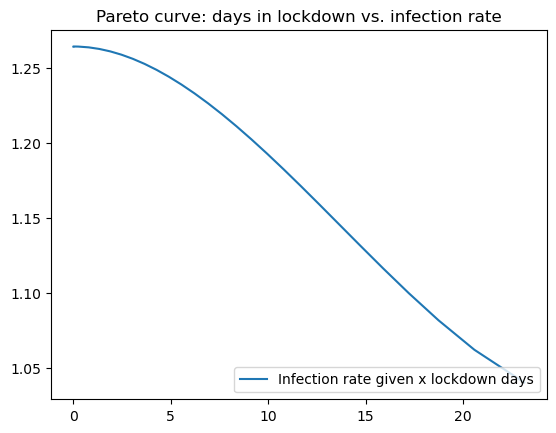

In [87]:
plot(lockdown_days, infection_rates)
legend(["Infection rate given x lockdown days"], loc="lower right");
title("Pareto curve: days in lockdown vs. infection rate")
print()

## 4. Conclusion ##
This pandemic has affected the world in a significant way, and thanks to work done by healthcare workers, scientists, and researchers, it may be soon coming to an end. Although the distribution of vaccines doesn't seem like too complicated of an issue, every wasted vaccine dose puts us farther behind in this fight. Our models show that although there are some tough decisions to be made, we can make it through successfully without causing too much harm to our lives.  

One main tradeoff policy makers will now have to look at is the relationship between vaccination rates and infection rates. Like our lockdown policy model above shows, infection rates can be kept low, but at what cost? As we move forward with increasing vaccination rates, we will begin to see loosening of restrictions on things like bars, concerts, and mass gatherings that have long been gone. Although many will be eager to get life back to normal, there will still be a portion of the population unvaccinated, whether it is their choice or not, and at risk. A future extension of this model we think would be interesting to pursue is how the metrics of infection rates, hospitalizations, and deaths are related to the vaccination percentage of a community. We know that herd immunity is real, but there is much disagreement over what vaccination rate is needed to keep these metrics under control. By gathering data in the coming weeks from cities and states who take different approaches to the loosening of restrictions, valuable information can be learned about this relationship. By fitting a regression model we could create a Pareto curve off of these estimations to provide policy makers with an idea of the results of different choices they could make. Understanding this will be useful in helping other states and countries successfully navigate out of the pandemic, and getting the world back to normal.

## Sources ##
Vaccine Allocations:  
https://data.cdc.gov/Vaccinations/COVID-19-Vaccine-Distribution-Allocations-by-Juris/b7pe-5nws  
https://data.cdc.gov/Vaccinations/COVID-19-Vaccine-Distribution-Allocations-by-Juris/saz5-9hgg  
https://data.cdc.gov/Vaccinations/COVID-19-Vaccine-Distribution-Allocations-by-Juris/w9zu-fywh  
Wisconsin Vaccine Daily Administered:  
https://www.dhs.wisconsin.gov/covid-19/vaccine-data.htm#summary  
Wisconsin Demographics:  
https://www.infoplease.com/us/census/wisconsin  
Lockdown Policy:  
https://publichealthmdc.com/coronavirus/dashboard  
https://covidactnow.org/us/wisconsin-wi/?s=1791710  
https://www.ahd.com/states/hospital_WI.html  
Hospital Data:  
https://publichealthmdc.com/coronavirus/dashboard  
https://covidactnow.org/us/wisconsin-wi/?s=1791710  
https://www.ahd.com/states/hospital_WI.html  
